In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers, Sequential
import PIL
import pathlib

In [20]:
import os

directories = os.listdir('../input/plant-village/PlantVillage')
for directory in directories:
    print(directory)

Pepper__bell___Bacterial_spot
Potato___healthy
Tomato_Leaf_Mold
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_Bacterial_spot
Tomato_Septoria_leaf_spot
Tomato_healthy
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato_Early_blight
Tomato__Target_Spot
Pepper__bell___healthy
Potato___Late_blight
Tomato_Late_blight
Potato___Early_blight
Tomato__Tomato_mosaic_virus


### Choosing only Potato Dataset

In [37]:
shutil.rmtree('/kaggle/working/')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/Potato___Early_blight'

In [38]:
!cp -rf ../input/plant-village/PlantVillage/Potato___Early_blight ./Potato___Early_blight

In [39]:
!cp -rf ../input/plant-village/PlantVillage/Potato___Late_blight ./Potato___Late_blight


In [40]:
!cp -rf ../input/plant-village/PlantVillage/Potato___healthy ./Potato___healthy


In [41]:
Current_Dir = os.getcwd()
dataset_dir = pathlib.Path(Current_Dir)
print(dataset_dir)
    
#shutil.rmtree('/kaggle/working/.virtual_documents')

directories = os.listdir(os.getcwd())
for directory in directories:
    print(directory)

/kaggle/working
Potato___Early_blight
Potato___Late_blight
Potato___healthy


In [73]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

In [43]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [44]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [45]:
len(dataset)

68

In [46]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


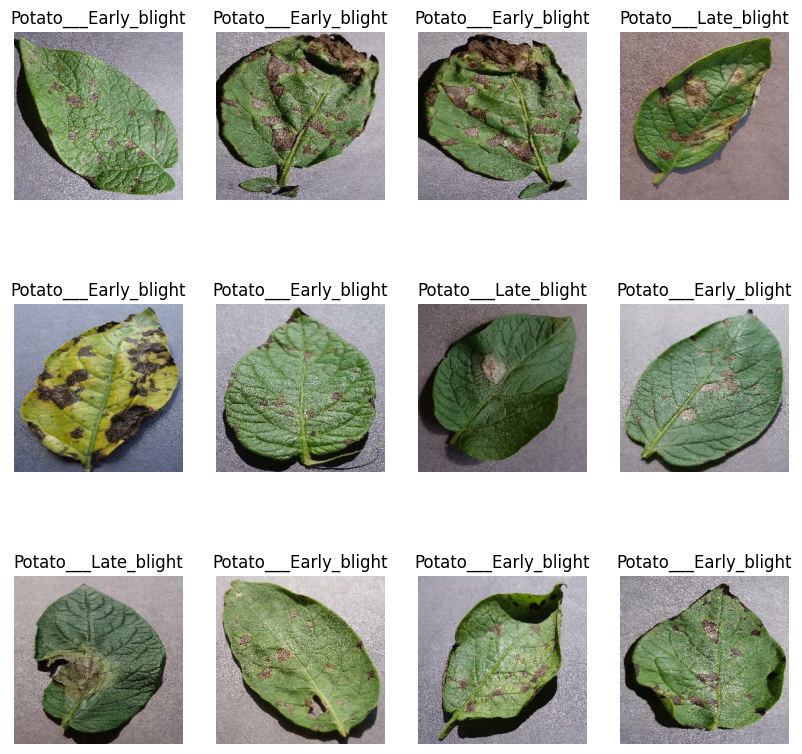

In [47]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [48]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [49]:
train_ds = dataset.take(54)
len(train_ds)

54

In [50]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [51]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [52]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [53]:
test_ds = test_ds.skip(6)
len(test_ds)

8

### Train Valid Test Function

In [54]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [55]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

### Caching and Prefetching

In [56]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Scaling

In [57]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation

In [58]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Model

In [61]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [62]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [63]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [65]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
54/54 [==============================] - 100s 2s/step - loss: 0.3079 - accuracy: 0.8756 - val_loss: 0.2521 - val_accuracy: 0.8802
Epoch 2/30
54/54 [==============================] - 99s 2s/step - loss: 0.2534 - accuracy: 0.9010 - val_loss: 0.1516 - val_accuracy: 0.9427
Epoch 3/30
54/54 [==============================] - 100s 2s/step - loss: 0.1443 - accuracy: 0.9456 - val_loss: 0.2112 - val_accuracy: 0.9010
Epoch 4/30
54/54 [==============================] - 100s 2s/step - loss: 0.1797 - accuracy: 0.9306 - val_loss: 0.1017 - val_accuracy: 0.9688
Epoch 5/30
54/54 [==============================] - 100s 2s/step - loss: 0.0904 - accuracy: 0.9664 - val_loss: 0.0557 - val_accuracy: 0.9688
Epoch 6/30
54/54 [==============================] - 102s 2s/step - loss: 0.0880 - accuracy: 0.9659 - val_loss: 0.0406 - val_accuracy: 0.9844
Epoch 7/30
54/54 [==============================] - 100s 2s/step - loss: 0.0790 - accuracy: 0.9676 - val_loss: 0.1112 - val_accuracy: 0.9427
Epoch 8/30
54/

In [66]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 518ms/step - loss: 0.0367 - accuracy: 0.9961


In [67]:
scores

[0.03666656091809273, 0.99609375]

In [68]:
history

In [69]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [70]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

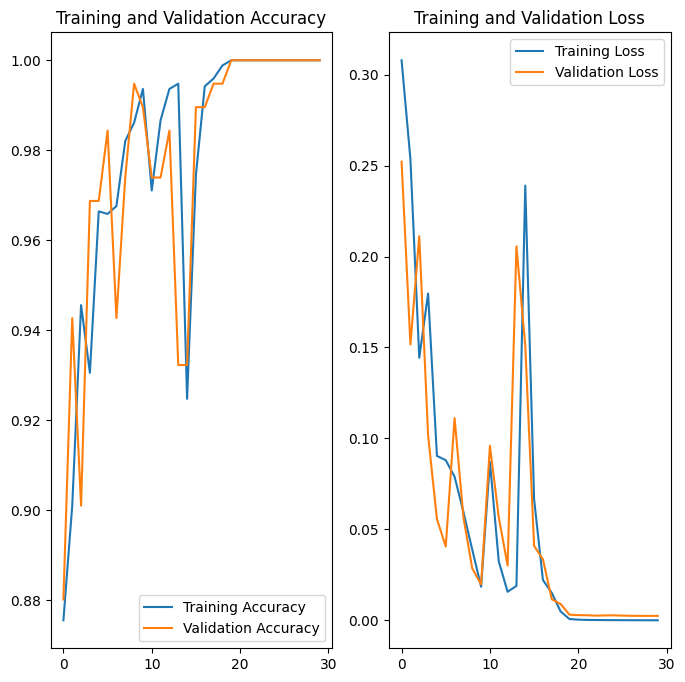

In [74]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Sample prediction

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 683ms/step
predicted label: Potato___Late_blight


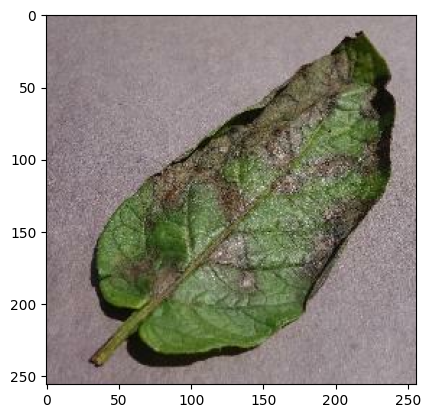

In [75]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [76]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 39ms/step


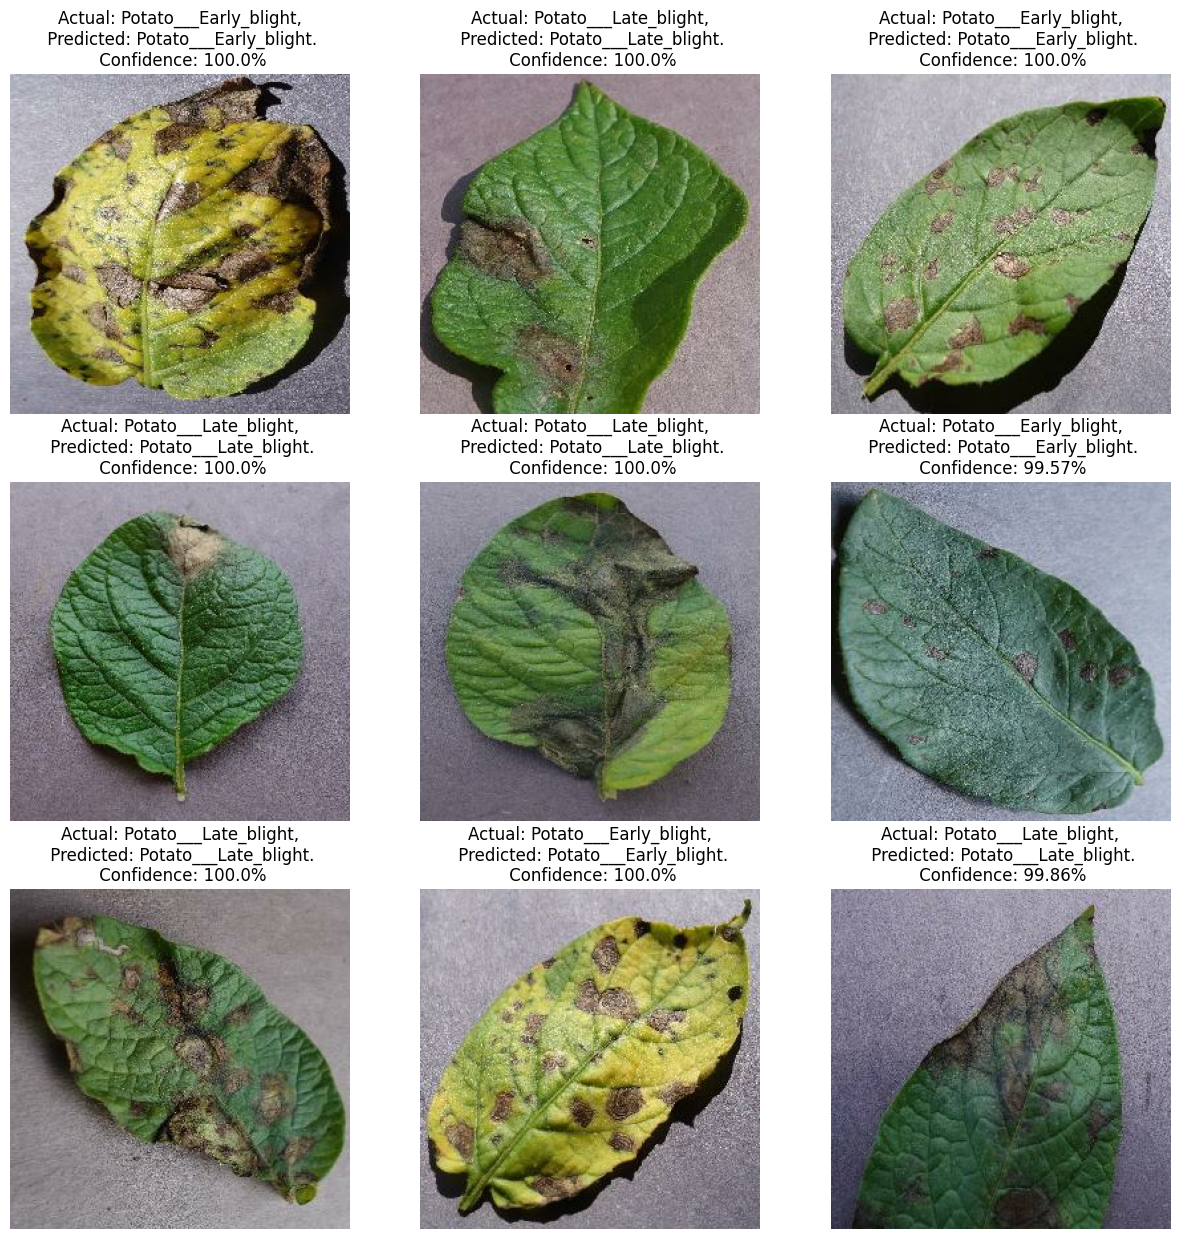

In [77]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")